In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install transformers einops scikit-learn pandas matplotlib tqdm


In [22]:
import pandas as pd

path = '/content/drive/MyDrive/genomics_project/data/benchmark_path_benign_snvs_grch37.csv'
df = pd.read_csv(path)

df = df[df['ClinicalSignificance'].isin(['Pathogenic', 'Benign'])]
df = df.dropna(subset=[
    'Chromosome', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF'
])

df['label'] = df['ClinicalSignificance'].map({'Pathogenic': 1, 'Benign': 0})

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (261267, 8)


,#AlleleID,GeneSymbol,Chromosome,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF,ClinicalSignificance,label
0,15044,FOXRED1,11,126145284,C,T,Pathogenic,1
1,15053,HFE,6,26093236,G,A,Benign,0
2,15057,HFE,6,26093443,G,T,Pathogenic,1
3,15059,WDR35,2,20189045,T,C,Pathogenic,1
4,15060,WDR35,2,20145548,T,C,Pathogenic,1


In [23]:
chr1_seq_lines = []
with open("/content/drive/MyDrive/genomics_project/data/chr1.fa", "r") as f:
    for line in f:
        if not line.startswith(">"):
            chr1_seq_lines.append(line.strip().upper())

chr1_sequence = ''.join(chr1_seq_lines)

print("chr1 length:", len(chr1_sequence))
print("chr1 bases 1,000,000–1,000,100:", chr1_sequence[1_000_000:1_000_100])


chr1 length: 249250621
chr1 bases 1,000,000–1,000,100: GGGCACAGCCTCACCCAGGAAAGCAGCTGGGGGTCCACTGGGCTCAGGGAAGACCCCCTGCCAGGGAGACCCCAGGCGCCTGAATGGCCACGGGAAGGAA


In [33]:
from collections import Counter

label_counts = Counter(df['label'])

label_names = {0: 'Benign', 1: 'Pathogenic'}
print("Total variant counts:")
for label, count in label_counts.items():
    print(f"{label_names[label]}: {count}")


Total variant counts:
Pathogenic: 6174
Benign: 15768


In [24]:
def get_sequence_window(row, flank=100):
    try:
        chrom = str(row['Chromosome']).lower()
        if chrom not in ["1", "chr1"]:
            return None

        pos = int(row['PositionVCF']) - 1
        ref = row['ReferenceAlleleVCF']
        alt = row['AlternateAlleleVCF']

        start = max(0, pos - flank)
        end = pos + flank + 1

        context = chr1_sequence[start:end]

        if len(context) != 2 * flank + 1:
            return None

        center = flank
        context = context[:center] + alt + context[center+1:]

        return context
    except Exception as e:
        return None

df['sequence'] = df.apply(get_sequence_window, axis=1)
df = df.dropna(subset=['sequence'])

print("Usable variants with sequence context:", df.shape[0])
df[['sequence', 'label']].head()


Usable variants with sequence context: 21942


,sequence,label
18,TAAAAAGAAAAAAATTGAGTTTAATATTAAAAATTAAAGTTTACTT...,1
19,GCCCTCTGTAGCCTGAGATCTGCTTTTTTCTAGATCATCTTTGCTA...,1
20,CTGGCTCTATCAGAGACCTCAGGCTAGTCACCAGCTGCTTCGCATC...,1
21,GATCATCTTTGCTAAGGATGGGCATTTTGCCCTGGAGGAGCTGGCC...,1
22,GGGCTCTGGAGGGCCTCAAGGCTGAGCCCTGTCTTCCCTCTGTATG...,1


In [25]:
from transformers import AutoTokenizer, AutoModel
import torch

model_name = "LongSafari/hyenadna-small-32k-seqlen-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

tokenization_hyena.py:   0%|          | 0.00/4.06k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/LongSafari/hyenadna-small-32k-seqlen-hf:
- tokenization_hyena.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


special_tokens_map.json:   0%|          | 0.00/971 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/981 [00:00<?, ?B/s]

configuration_hyena.py:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/LongSafari/hyenadna-small-32k-seqlen-hf:
- configuration_hyena.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_hyena.py:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/LongSafari/hyenadna-small-32k-seqlen-hf:
- modeling_hyena.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

HyenaDNAModel(
  (backbone): HyenaLMBackbone(
    (embeddings): HyenaEmbeddings(
      (word_embeddings): Embedding(16, 256)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0-3): 4 x HyenaBlock(
        (mixer): HyenaOperator(
          (dropout): Dropout(p=0.0, inplace=False)
          (in_proj): Linear(in_features=256, out_features=768, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
          (short_filter): Conv1d(768, 768, kernel_size=(3,), stride=(1,), padding=(2,), groups=768)
          (filter_fn): HyenaFilter(
            (dropout): Dropout(p=0.0, inplace=False)
            (pos_emb): HyenaPositionalEmbedding()
            (implicit_filter): Sequential(
              (0): Linear(in_features=5, out_features=64, bias=True)
              (1): HyenaSin()
              (2): Linear(in_features=64, out_features=64, bias=True)
              (3): HyenaSin()
              (4): Linear(in_features=64, out_features=6

In [35]:
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np
import collections

accuracies, f1_scores, roc_aucs = [], [], []

for seed in [0, 1, 2, 3, 4]:
    print(f"\nSNV Pathogenicity Run {seed+1}")
    n_per_class = 1200
    df_pos = df[df['label'] == 1].sample(n=n_per_class, random_state=seed)
    df_neg = df[df['label'] == 0].sample(n=n_per_class, random_state=seed)
    df_sampled = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=seed)  # shuffle

    sequences = df_sampled['sequence'].tolist()
    labels = df_sampled['label'].tolist()

    embeddings = []
    for seq in tqdm(sequences, desc=f"Embedding Run {seed+1}"):
        inputs = tokenizer(seq, return_tensors="pt", truncation=True, padding="max_length", max_length=1024)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        pooled = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        embeddings.append(pooled)

    embeddings = np.array(embeddings)
    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=seed)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    accuracies.append(acc)
    f1_scores.append(f1)
    roc_aucs.append(auc)

    print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC AUC: {auc:.4f}")



SNV Pathogenicity Run 1


Embedding Run 1: 100%|██████████| 2400/2400 [00:14<00:00, 162.04it/s]


Accuracy: 0.5583, F1: 0.5726, ROC AUC: 0.6002

SNV Pathogenicity Run 2


Embedding Run 2: 100%|██████████| 2400/2400 [00:14<00:00, 162.55it/s]


Accuracy: 0.5833, F1: 0.5918, ROC AUC: 0.6240

SNV Pathogenicity Run 3


Embedding Run 3: 100%|██████████| 2400/2400 [00:14<00:00, 163.53it/s]


Accuracy: 0.6062, F1: 0.6151, ROC AUC: 0.6536

SNV Pathogenicity Run 4


Embedding Run 4: 100%|██████████| 2400/2400 [00:14<00:00, 161.75it/s]


Accuracy: 0.6229, F1: 0.6565, ROC AUC: 0.6383

SNV Pathogenicity Run 5


Embedding Run 5: 100%|██████████| 2400/2400 [00:14<00:00, 164.13it/s]


Accuracy: 0.5813, F1: 0.6036, ROC AUC: 0.5848


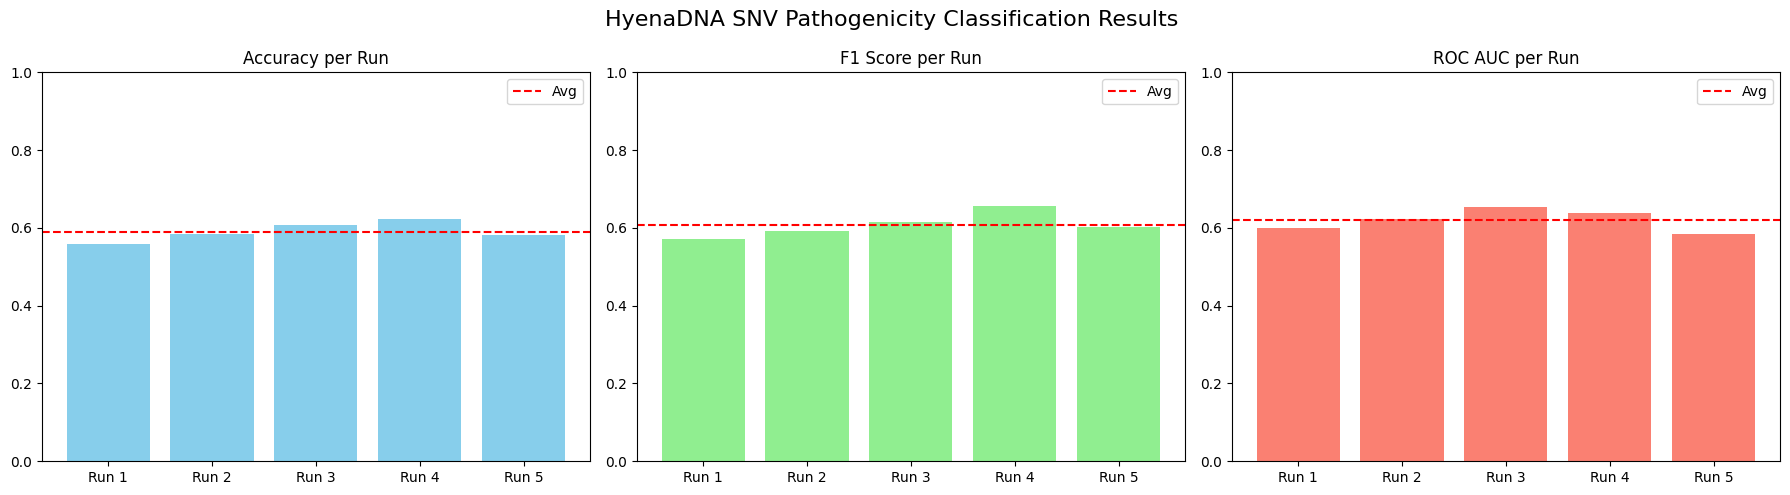

In [36]:
import matplotlib.pyplot as plt

runs = [f"Run {i+1}" for i in range(5)]

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].bar(runs, accuracies, color='skyblue')
axs[0].axhline(y=np.mean(accuracies), color='red', linestyle='--', label='Avg')
axs[0].set_title('Accuracy per Run')
axs[0].set_ylim(0, 1)
axs[0].legend()

axs[1].bar(runs, f1_scores, color='lightgreen')
axs[1].axhline(y=np.mean(f1_scores), color='red', linestyle='--', label='Avg')
axs[1].set_title('F1 Score per Run')
axs[1].set_ylim(0, 1)
axs[1].legend()

axs[2].bar(runs, roc_aucs, color='salmon')
axs[2].axhline(y=np.mean(roc_aucs), color='red', linestyle='--', label='Avg')
axs[2].set_title('ROC AUC per Run')
axs[2].set_ylim(0, 1)
axs[2].legend()

fig.suptitle('HyenaDNA SNV Pathogenicity Classification Results ', fontsize=16)
plt.tight_layout()
plt.show()